<a href="https://colab.research.google.com/github/michael-L-i/CS229-Final-Project/blob/main/Standard_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import pandas as pd
import sys
import random
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# ========================
# SET RANDOMNESS
# ========================

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# ========================
# PARAMETERS AND LOGGING
# ========================

# Set up logging to both file and console
handler = logging.StreamHandler(sys.stdout)
handler.flush = sys.stdout.flush
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training_log.log'),
        handler
    ]
)

# Base configuration dictionary for easy tuning
base_config = {
    "resnet_version": 50,  # Options: 18, 34, 50, 101, 152
    "batch_size": 32,
    "learning_rate": 0.00005,
    "weight_decay": 1e-4,
    "num_epochs": 5,
    "momentum": 0.9,
    "use_scheduler": True,
}

# define num_workers for speedup
n_workers = 15


In [10]:
# ========================
# DATASET DEFINITIONS
# ========================

class RecaptureDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        """
        For training/validation/testing, expects two subfolders:
        'SingleCaptureImages' (label 0) and 'RecapturedImages' (label 1).
        """
        self.transform = transform
        self.is_test = is_test

        self.single_capture_path = os.path.join(root_dir, 'SingleCaptureImages')
        self.recapture_path = os.path.join(root_dir, 'RecapturedImages')
        self.single_capture_images = []
        self.recapture_images = []
        # Get images from SingleCaptureImages
        for root, _, files in os.walk(self.single_capture_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.single_capture_images.append(os.path.join(root, file))
        # Get images from RecapturedImages
        for root, _, files in os.walk(self.recapture_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.recapture_images.append(os.path.join(root, file))
        self.all_images = self.single_capture_images + self.recapture_images
        self.labels = ([0] * len(self.single_capture_images)) + ([1] * len(self.recapture_images))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ========================
# TRANSFORMATIONS
# ========================

# Transformations for training/validation/testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ========================
# DATASET & DATALOADERS
# ========================

# root directory
root_dir = "/content/drive/MyDrive/Colab Notebooks/ROSE Dataset/dataset"

# create the full dataset
full_dataset = RecaptureDataset(root_dir=root_dir, transform=train_transform, is_test=False)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
logging.info(f"Total images: {dataset_size}, Training: {train_size}, Validation: {val_size}, Testing: {test_size}")

# seed so that we can reproduce
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

def get_dataloaders(config, train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True,
                              num_workers=n_workers, pin_memory=True, persistent_workers=True,
                              prefetch_factor=3)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False,
                             num_workers=n_workers, pin_memory=True, persistent_workers=True,
                             prefetch_factor=3)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False,
                             num_workers=n_workers, pin_memory=True, persistent_workers=True,
                             prefetch_factor=3)
    return train_loader, val_loader, test_loader

# ========================
# MODEL DEFINITION
# ========================

class RecaptureResNet(nn.Module):
    def __init__(self, resnet_version=18):
        super(RecaptureResNet, self).__init__()

        # choose which model we want
        resnet_models = {
            18: models.resnet18,
            34: models.resnet34,
            50: models.resnet50,
            101: models.resnet101,
            152: models.resnet152,
        }
        # Load the pretrained ResNet model (default 3-channel input)
        self.model = resnet_models[resnet_version](pretrained=True)

        # Modify the fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========================
# TRAINING & EVALUATION FUNCTIONS
# ========================

def train_and_evaluate(config, train_dataset, val_dataset, test_dataset):
    train_loader, val_loader, test_loader = get_dataloaders(config, train_dataset, val_dataset, test_dataset)
    model = RecaptureResNet(resnet_version=config["resnet_version"]).to(device)

    # Weighted binary cross entropy: Increase weight for class 1 (due to past results)
    pos_weight = torch.tensor([3.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) if config["use_scheduler"] else None

    train_losses = []
    model.train()
    for epoch in range(config["num_epochs"]):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}", leave=True):
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        if scheduler:
            scheduler.step()
        logging.info(f"Epoch {epoch+1}/{config['num_epochs']} - Loss: {epoch_loss:.4f}")
        print(f"Epoch {epoch+1}/{config['num_epochs']} - Loss: {epoch_loss:.4f}")

        # Evaluate on validation set at the end of each epoch
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Evaluating on Validation", leave=True):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predictions = (torch.sigmoid(outputs) > 0.5).int()
                val_correct += (predictions.view(-1) == labels).sum().item()
                val_total += labels.size(0)
        val_accuracy = 100 * val_correct / val_total
        logging.info(f"Epoch {epoch+1}/{config['num_epochs']} - Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{config['num_epochs']} - Validation Accuracy: {val_accuracy:.2f}%")
        model.train()

    # Final evaluation on test set
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on Test", leave=True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).int()
            test_correct += (predictions.view(-1) == labels).sum().item()
            test_total += labels.size(0)
    test_accuracy = 100 * test_correct / test_total
    logging.info(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return train_losses, val_accuracy, test_accuracy, model

In [11]:
# ========================
# SAVE & LOAD MODEL
# ========================

tuned_config = {
    "resnet_version": 50,  # Options: 18, 34, 50, 101, 152
    "batch_size": 128,
    "learning_rate": 5e-5,
    "weight_decay": 1e-4,
    "num_epochs": 15,
    "use_scheduler": True,
}

# Train the model with the tuned configuration using the 8:1:1 split
_, _, _, model = train_and_evaluate(tuned_config, train_dataset, val_dataset, test_dataset)

# save model
model_path = f'recapture_resnet{tuned_config["resnet_version"]}.pth'
torch.save(model.state_dict(), model_path)
logging.info(f"Model saved as {model_path}")
print(f"Model saved as {model_path}")

Epoch 1/15: 100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


Epoch 1/15 - Loss: 0.7220


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.35s/it]


Epoch 1/15 - Validation Accuracy: 85.90%


Epoch 2/15: 100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


Epoch 2/15 - Loss: 0.1934


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.11s/it]


Epoch 2/15 - Validation Accuracy: 87.18%


Epoch 3/15: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


Epoch 3/15 - Loss: 0.0833


Evaluating on Validation: 100%|██████████| 2/2 [00:15<00:00,  7.95s/it]


Epoch 3/15 - Validation Accuracy: 93.16%


Epoch 4/15: 100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


Epoch 4/15 - Loss: 0.0344


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.02s/it]


Epoch 4/15 - Validation Accuracy: 98.29%


Epoch 5/15: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Epoch 5/15 - Loss: 0.0140


Evaluating on Validation: 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]


Epoch 5/15 - Validation Accuracy: 98.72%


Epoch 6/15: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


Epoch 6/15 - Loss: 0.0091


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.08s/it]


Epoch 6/15 - Validation Accuracy: 100.00%


Epoch 7/15: 100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


Epoch 7/15 - Loss: 0.0063


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.15s/it]


Epoch 7/15 - Validation Accuracy: 100.00%


Epoch 8/15: 100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


Epoch 8/15 - Loss: 0.0058


Evaluating on Validation: 100%|██████████| 2/2 [00:15<00:00,  7.94s/it]


Epoch 8/15 - Validation Accuracy: 100.00%


Epoch 9/15: 100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


Epoch 9/15 - Loss: 0.0061


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.15s/it]


Epoch 9/15 - Validation Accuracy: 100.00%


Epoch 10/15: 100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


Epoch 10/15 - Loss: 0.0046


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.02s/it]


Epoch 10/15 - Validation Accuracy: 100.00%


Epoch 11/15: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Epoch 11/15 - Loss: 0.0058


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.02s/it]


Epoch 11/15 - Validation Accuracy: 100.00%


Epoch 12/15: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Epoch 12/15 - Loss: 0.0049


Evaluating on Validation: 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]


Epoch 12/15 - Validation Accuracy: 100.00%


Epoch 13/15: 100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


Epoch 13/15 - Loss: 0.0058


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it]


Epoch 13/15 - Validation Accuracy: 100.00%


Epoch 14/15: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


Epoch 14/15 - Loss: 0.0056


Evaluating on Validation: 100%|██████████| 2/2 [00:16<00:00,  8.07s/it]


Epoch 14/15 - Validation Accuracy: 100.00%


Epoch 15/15: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


Epoch 15/15 - Loss: 0.0043


Evaluating on Validation: 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]


Epoch 15/15 - Validation Accuracy: 100.00%


Evaluating on Test: 100%|██████████| 2/2 [00:17<00:00,  8.53s/it]


Test Accuracy: 98.72%
Model saved as recapture_resnet50.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

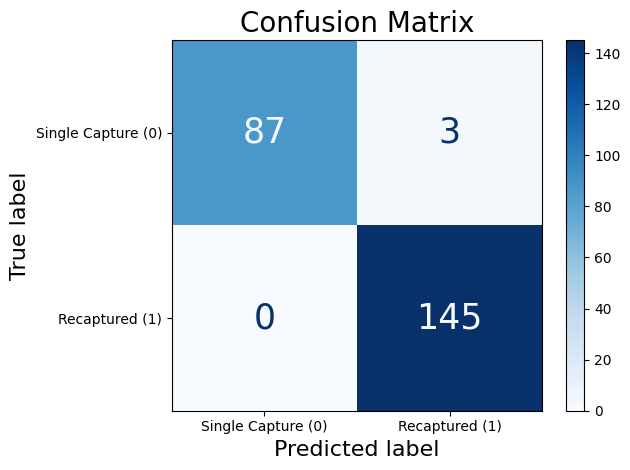

In [22]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=n_workers,
                        pin_memory=True, persistent_workers=True, prefetch_factor=3)
model.eval()

# lists to collect ground truth labels and predictions
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Single Capture (0)", "Recaptured (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel(plt.gca().get_xlabel(), fontsize=16)
plt.ylabel(plt.gca().get_ylabel(), fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
for text in disp.text_.ravel():
    text.set_fontsize(25)

plt.tight_layout()
plt.show()